## Week 5, Lab 2: Tackling an NLP Problem with Naive Bayes
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we are going to apply a **new** modeling technique to natural language processing data.

> "But how can we apply a modeling technique we haven't learned?!"

The DSI program is great - but we can't teach you *everything* about data science in 12 weeks! This lab is designed to help you start learning something new without it being taught in a formal lesson. 
- Later in the cohort (like for your capstone!), you'll be exploring models, libraries, and resources that you haven't been explicitly taught.
- After the program, you'll want to continue developing your skills. Being comfortable with documentation and being confident in your ability to read something new and decide whether or not it is an appropriate method for the problem you're trying to solve is **incredibly** valuable.

## Step 1: Define the problem.

Many organizations have a substantial interest in classifying users of their product into groups. Some examples:
- A company that serves as a marketplace may want to predict who is likely to purchase a certain type of product on their platform, like books, cars, or food.
- An application developer may want to identify which individuals are willing to pay money for "bonus features" or to upgrade their app.
- A social media organization may want to identify who generates the highest rate of content that later goes "viral."

### Summary
In this lab, you're an engineer for Facebook. In recent years, the organization Cambridge Analytica gained worldwide notoriety for its use of Facebook data in an attempt to sway electoral outcomes.

Cambridge Analytica, an organization staffed with lots of Ph.D. researchers, used the Big5 personality groupings (also called OCEAN) to group people into one of 32 different groups.
- The five qualities measured by this personality assessment are:
    - **O**penness
    - **C**onscientiousness
    - **E**xtroversion
    - **A**greeableness
    - **N**euroticism
- Each person could be classified as "Yes" or "No" for each of the five qualities.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$)
- You don't have to check it out, but if you want to learn more about this personality assessment, head to [the Wikipedia page](https://en.wikipedia.org/wiki/Big_Five_personality_traits).
- There's also [a short (3-4 pages) academic paper describing part of this approach](./celli-al_wcpr13.pdf).

Cambridge Analytica's methodology was, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big5 personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

You want to know the **real-world problem**: "Is what Cambridge Analytica attempted to do actually possible, or is it junk science?"

However, we'll solve the related **data science problem**: "Are one's Facebook statuses predictive of whether or not one is agreeable?"
> Note: If Facebook statuses aren't predictive of one being agreeable (one of the OCEAN qualities), then Cambridge Analytica's approach won't work very well!

## Step 2: Obtain the data.

Obviously, there are plenty of opportunities to discuss the ethics surrounding this particular issue... so let's do that.

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./mypersonality_final.csv', encoding = 'ISO-8859-1')

In [3]:
data.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,NETWORKSIZE,BETWEENNESS,NBETWEENNESS,DENSITY,BROKERAGE,NBROKERAGE,TRANSITIVITY
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she ca...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
2,b7b7764cfa1c523e4e93ab2a79a946c4,is sore and wants the knot of muscles at the b...,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,180.0,14861.6,93.29,0.03,15661.0,0.49,0.1


### 1. What is the difference between anonymity and confidentiality? All else held equal, which tends to keep people safer?

Anonymity means the subject can't be identified from the data. Confidentiality means participants can be identified from the data, but only certain people (like researchers) have access to the data. Anonymity usually keeps people safer because confidential data can be leaked or inappropriately accessed. 

Sources: https://www.statisticssolutions.com/what-is-the-difference-between-anonymity-and-confidentiality/

### 2. Suppose that the "unique identifier" in the above data, the `#AUTHID`, is a randomly generated key so that it can never be connected back to the original poster. Have we guaranteed anonymity here? Why or why not?

We haven't guaranteed anonymity because the posts themselves might still contain personally identifiable information, like addresses, phone numbers, names of family members, etc.

### 3. As an engineer for Facebook, you recognize that user data will be used by Facebook and by other organizations - that won't change. However, what are at least three recommendations you would bring to your manager to improve how data is used and shared? Be as specific as you can.

## Step 3: Explore the data.

- Note: For our $X$ variable, we will only use the `STATUS` variable. For our $Y$ variable, we will only use the `cAGR` variable.

### 4. Explore the data here.
> We aren't explicitly asking you to do specific EDA here, but what EDA would you generally do with this data? Do the EDA you usually would, especially if you know what the goal of this analysis is.

In [4]:
X = data['STATUS']
y = data['cAGR'].map(lambda x: 1 if x == 'y' else 0)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

cv = CountVectorizer()
cv.fit(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [6]:
words = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())

In [7]:
words.sum().sort_values(ascending=False).head(20)

the         3805
to          3398
is          2386
and         2286
of          1574
in          1468
it          1237
for         1206
my          1158
you         1148
propname     997
that         869
on           847
with         713
be           661
me           613
at           594
this         565
have         549
so           543
dtype: int64

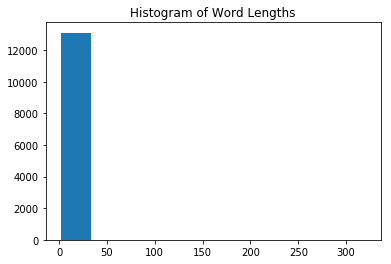

In [8]:
lengths_of_words = [len(each) for each in words.columns]
plt.hist(lengths_of_words)
plt.title('Histogram of Word Lengths');

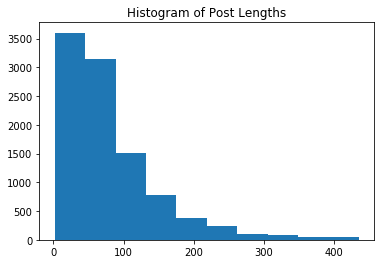

In [9]:
lengths_of_posts = [len(each) for each in X]
plt.hist(lengths_of_posts)
plt.title('Histogram of Post Lengths');

### 5. What is the difference between CountVectorizer and TFIDFVectorizer?

Count vectorizer brings back a numeric representation of how often certain words show up in a document, but the TFIDF vectorizer brings back the TF-IDF score per word in a document.

### 6. What are stopwords?

They're words we want to filter out before doing our NLP analysis. They're common words that may not have value for the data science task at hand.

### 7. Give an example of when you might remove stopwords.

If we have reason to believe they're not useful.

### 8. Give an example of when you might keep stopwords in your model.

If we have reason to believe stopwords might be important, e.g. attributing authorship or determining what century a text came from.

## Step 4: Model the data.

We are going to fit two types of models: a logistic regression and [a Naive Bayes classifier](https://scikit-learn.org/stable/modules/naive_bayes.html).

**Reminder:** We will only use the feature `STATUS` to model `cAGR`.

### We want to attempt to fit our models on sixteen sets of features:

1. CountVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
2. CountVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
3. CountVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
4. CountVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
5. CountVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
6. CountVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
7. CountVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
8. CountVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.
9. TFIDFVectorizer with 100 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
10. TFIDFVectorizer with 100 features, with English stopwords removed and with the default `ngram_range`.
11. TFIDFVectorizer with 100 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
12. TFIDFVectorizer with 100 features, with English stopwords kept in and with the default `ngram_range`.
13. TFIDFVectorizer with 500 features, with English stopwords removed and with an `ngram_range` that includes 1 and 2.
14. TFIDFVectorizer with 500 features, with English stopwords removed and with the default `ngram_range`.
15. TFIDFVectorizer with 500 features, with English stopwords kept in and with an `ngram_range` that includes 1 and 2.
16. TFIDFVectorizer with 500 features, with English stopwords kept in and with the default `ngram_range`.

### 9. Rather than doing this directly (e.g. instantiating 16 different vectorizers), what have we learned about that might make this easier? Use it.

In [10]:
pipe_cv = Pipeline([
    ('cv', CountVectorizer()),
    ('lr', LogisticRegressionCV())
])

params_grid = {
    'cv__max_features': [100, 500],
    'cv__stop_words': ['english', None],
    'cv__ngram_range': [(1,1), (1,2)]
}

gs_cv = GridSearchCV(pipe_cv, params_grid)
gs_cv.fit(X_train, y_train)
gs_cv.score(X_train, y_train), gs_cv.score(X_test, y_test)

(0.6048137689928734, 0.5443548387096774)

In [11]:
pipe_tf = Pipeline([
    ('tf', TfidfVectorizer()),
    ('lr', LogisticRegressionCV())
])

params_grid = {
    'tf__max_features': [100, 500],
    'tf__stop_words': ['english', None],
    'tf__ngram_range': [(1,1), (1,2)]
}

gs_tf = GridSearchCV(pipe_tf, params_grid)
gs_tf.fit(X_train, y_train)
gs_tf.score(X_train, y_train), gs_cv.score(X_test, y_test)

(0.6244453408632513, 0.5443548387096774)

### 10. What are some of the advantages of fitting a logistic regression model?

Logistic regression is very interpretable. We can easily tell which variables are considered important by the model.

### 11. Fit a logistic regression model and compare it to the baseline.

The baseline is about .53:

In [12]:
y_train.value_counts(normalize=True)

1    0.531263
0    0.468737
Name: cAGR, dtype: float64

The logistic regression performs a little better than the baseline:

In [13]:
lr = LogisticRegressionCV()

lr.fit(X_train_cv, y_train)
lr.score(X_train_cv, y_train), lr.score(X_test_cv, y_test)

(0.863116848191475, 0.5846774193548387)

### Summary of Naive Bayes 

Naive Bayes is a classification technique that relies on probability to classify observations.
- It's based on a probability rule called **Bayes' Theorem**... thus, "**Bayes**."
- It makes an assumption that isn't often met, so it's "**naive**."

Despite being a model that relies on a naive assumption, it performs **really** well.
- [Interested in details? Read more here if you want.](https://www.cs.unb.ca/~hzhang/publications/FLAIRS04ZhangH.pdf)


The [sklearn documentation](https://scikit-learn.org/stable/modules/naive_bayes.html) is here, but it can be intimidating. So, to quickly summarize the Bayes and Naive parts of the model...

#### Bayes' Theorem
If you've seen Bayes' Theorem, it relates the conditional probability of $P(A|B)$ to $P(B|A)$. (Don't worry; we won't be doing any probability calculations by hand! However, you may want to refresh your memory on conditional probability from our earlier lessons if you forget what a conditional probability is.)

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

- Let $A$ be that someone is "agreeable," like the OCEAN category.
- Let $B$ represent the words used in their Facebook post.

$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)} \\
\Rightarrow P(\text{person is agreeable}|\text{words in Facebook post}) &=& \frac{P(\text{words in Facebook post}|\text{person is agreeable})P(\text{person is agreeable})}{P(\text{words in Facebook post})}
\end{eqnarray*}
$$

We want to calculate the probability that someone is agreeable **given** the words that they used in their Facebook post! (Rather than calculating this probability by hand, this is done under the hood and we can just see the results by checking `.predict_proba()`.) However, this is exactly what our model is doing. We can (a.k.a. the model can) calculate the pieces on the right-hand side of the equation to give us a probability estimate of how likely someone is to be agreeable given their Facebook post.

#### Naive Assumption

If our goal is to estimate $P(\text{person is agreeable}|\text{words in Facebook post})$, that can be quite tricky.

---

<details><summary>Bonus: if you want to understand why that's complicated, click here.</summary>
    
- The event $\text{"words in Facebook post"}$ is a complicated event to calculate.

- If a Facebook post has 100 words in it, then the event $\text{"words in Facebook post"} = \text{"word 1 is in the Facebook post" and "word 2 is in the Facebook post" and }\ldots \text{ and "word 100 is in the Facebook post"}$.

- To calculate the joint probability of all 100 words being in the Facebook post gets complicated pretty quickly. (Refer back to the probability notes on how to calculate the joint probability of two events if you want to see more.)
</details>

---

To simplify matters, we make an assumption: **we assume that all of our features are independent of one another.**

In some contexts, this assumption might be realistic!

### 12. Why would this assumption not be realistic with NLP data?

> Language data isn't independent. Certain words are more likely to follow other words, and certain words are less likely to follow other words.

Despite this assumption not being realistic with NLP data, we still use Naive Bayes pretty frequently.
- It's a very fast modeling algorithm. (which is great especially when we have lots of features and/or lots of data!)
- It is often an excellent classifier, outperforming more complicated models.

There are three common types of Naive Bayes models: Bernoulli Naive Bayes, Multinomial Naive Bayes, and Gaussian Naive Bayes.
- How do we pick which of the three models to use? It depends on our $X$ variable.
    - Bernoulli Naive Bayes is appropriate when our features are all 0/1 variables.
        - [Bernoulli NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB)
    - Multinomial Naive Bayes is appropriate when our features are variables that take on only positive integer counts.
        - [Multinomial NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)
    - Gaussian Naive Bayes is appropriate when our features are Normally distributed variables. (Realistically, though, we kind of use Gaussian whenever neither Bernoulli nor Multinomial works.)
        - [Gaussian NB Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB)

### 13. Suppose you CountVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.

> We fit multinomial Naive Bayes because count vectorizer gives us an integer count of words in a document.

In [14]:
mnb = MultinomialNB()

mnb.fit(X_train_cv, y_train)
mnb.score(X_train_cv, y_train), mnb.score(X_test_cv, y_test)

(0.8656716417910447, 0.6020161290322581)

### 14. Suppose you TFIDFVectorized your features. Which Naive Bayes model would be most appropriate to fit? Why? Fit it.

> We fit Gaussian Naive Bayes because TF-IDF brings back a float rather than integer counts or just zeros and ones (thereby precluding use of Multinomial or Bernoulli Naive Bayes.)

In [15]:
tf = TfidfVectorizer()

tf.fit(X_train, y_train)
X_train_tf = tf.transform(X_train).todense()
X_test_tf = tf.transform(X_test).todense()

gnb = GaussianNB()

gnb.fit(X_train_tf, y_train)
gnb.score(X_train_tf, y_train), gnb.score(X_test_tf, y_test)

(0.8695710636009143, 0.5495967741935484)

### 15. Compare the performance of your models.

It's very hard to improve on the baseline.

### 16. Even though we didn't explore the full extent of Cambridge Analytica's modeling, based on what we did here, how effective was their approach at using Facebook data to model agreeableness?